# Домашнее задание №3. Неопределенность оптимального портфеля. Оптимизация CVaR.
#### Выполнили: Мельников, Малышева, Селивановская

Целью работы является оценка неопределенности оптимального портфеля для нормального многомерного распределения и двух способов вычисления оптимального портфеля (оптимизация в модели Марковица и оптимизация CVaR)

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import scipy
import math
import seaborn as sns
import warnings
from random import randint
from scipy.optimize import minimize
from matplotlib.ticker import ScalarFormatter
warnings.filterwarnings('ignore')

from IPython.display import clear_output

#### Вспомогательные функции: 

In [6]:
# загрузка данных либо с yahoo finance, либо из локального файла
def download_data(tickers_list, year, local_file=False, dropna=True):
    if not local_file:
        data = yf.download(tickers_list, f'{year}-01-01',f'{year}-12-31') # ! 
    else:
        data = pd.read_pickle('ticker_data')
    
    if dropna:
        data.dropna(axis=1, inplace=True)    
    
    adj_close = data['Adj Close']    
    tickers = adj_close.columns
    dates = adj_close.index
    log_returns = pd.DataFrame(index=adj_close.index[1:], columns=adj_close.columns)
    
    for date_index in range(1, len(dates)):
        for ticker in tickers:
            prev_adj_close = adj_close.loc[dates[date_index - 1], ticker]
            curr_adj_close = adj_close.loc[dates[date_index], ticker]        
            log_returns.loc[dates[date_index], ticker] = np.log(curr_adj_close/prev_adj_close)
    
    return log_returns
# TODO: compare the results

'''
def download_data(tickers_list, year, local_file=False, reduce_tickers=False, add_index=False):   
        
    if not local_file:
        data = yf.download(tickers_list, f'{year}-01-01',f'{year}-12-31') # ! 
    else:
        data = pd.read_pickle('ticker_data')
    
    data = data.drop(columns = ['Low', 'High', 'Open', 'Close'])
    
    if add_index:
        index = pd.read_csv('index_ixic.csv', sep=",")
        index = index.drop(columns = ['Low', 'High', 'Open', 'Close'])
    
    adj_close = data['Adj Close'] # adjusted closing price
    volume = data['Volume'] # sales volume

    adj_close.reset_index(level=0, inplace=True) # set index from date to int
    volume.reset_index(level=0, inplace=True)
    
    
    for i in range(0, len(adj_close['Date'])):
        volume.loc[i, 'Date'] = str(volume['Date'][i].date())
        adj_close.loc[i, 'Date'] = str(adj_close['Date'][i].date())


    adj_indexes = set(adj_close['Date'].to_list())
    ind_indexes = set(index['Date'].to_list())
    diff = adj_indexes.difference(ind_indexes)
    
    adj_close = adj_close.loc[adj_close['Date'] != f'{year}-11-28']
    volume = volume.loc[volume['Date'] != f'{year}-11-28']

    #handling missing values
    adj_close = adj_close.dropna(axis=1, how='any')
    volume = volume.dropna(axis=1, how='any')

    #add the index data to the main data
    if add_index:
        adj_close['IXIC'] = index['Adj Close']
        volume['IXIC'] = index['Volume']

    #delete last day as ixic is nan
    adj_close = adj_close.loc[adj_close['Date'] != f'{year}-12-30']
    volume = volume.loc[volume['Date'] != f'{year}-12-30']

    #reindex after drop
    adj_close.reset_index(drop=True, inplace=True)

    #reduce the number of tickers
    
    if reduce_tickers is True:
        tickers_to_delete = adj_close.columns.to_list()
        tickers_to_delete.remove('Date')
        tickers_to_delete.remove('IXIC')
        tickers_to_delete = tickers_to_delete[::2]
        adj_close.drop(tickers_to_delete, inplace=True, axis=1) 
        volume.drop(tickers_to_delete, inplace=True, axis=1) 

    # calculate logarithmic returns
    log_returns = pd.DataFrame(index = adj_close.index, columns = adj_close.columns)
    log_returns['Date'] = adj_close['Date']
    tickers = adj_close.columns.to_list()
    tickers.remove('Date')

    #num_days=len(log_returns['AADR'])
    num_days=len(log_returns[tickers[0]])
    print(len(tickers))
    
    for ticker in tickers:
        for i in range(1, num_days):
            log_returns.loc[i, ticker] = np.log(adj_close.loc[i, ticker]/adj_close.loc[i-1, ticker])
    #dropping first day
    log_returns = log_returns.dropna(axis=0, how='any')
    log_returns.reset_index( drop=True, inplace=True) 
    
    if add_index:        
        index_log_returns = log_returns.loc[:, ["Date", "IXIC"]]
        log_returns.drop(columns=['IXIC'], axis=0, inplace=True)
        
        return log_returns, index_log_returns
    
    return log_returns
'''

# выборочные средние 
def calc_sample_means(returns):
    tickers = returns.columns # предполагаем, что первый столбец - дата 
    sample_means = pd.DataFrame(columns = ['Sample mean (E)'], index = tickers)
    for ticker in tickers:
        mean = np.mean(returns[ticker])
        sample_means['Sample mean (E)'][ticker] = mean
    return sample_means

# матрица выборочных ковариаций
def calc_sample_cov(returns, sample_means, verbose=True):
    tickers = returns.columns
    sample_cov = pd.DataFrame(columns = tickers, index = tickers)
    status_count = 0
    for ticker1 in tickers:    
        if verbose:
            status_count += 1
            clear_output()
            print(f"{status_count}/{len(tickers)}")

        for ticker2 in tickers:
            sum_ = 0
            N = returns[ticker2].shape[0] # количество наблюдений
            for i in range(N):
                sum_ += (returns[ticker1][i] - float(sample_means.loc[ticker1])) * (returns[ticker2][i] - float(sample_means.loc[ticker2]))

            sample_cov[ticker1][ticker2] = sum_ / (N)
    return sample_cov

# доходность портфеля
def calc_portfolio_return(x, means): 
    #E = sum(means.iloc[0:n_stocks] * x)
    #E = np.matmul(x, means)
    E = np.matmul(x, means.to_numpy())
    E = float(E)
    return E

# риск портфеля
def calc_portfolio_volatility(x, cov_matrix): 
    #sigma_sq = np.matmul(np.matmul(x, cov_matrix), x.T)
    sigma_sq = np.matmul(np.matmul(x, cov_matrix.to_numpy()), x.T)
    sigma_sq = float(sigma_sq)
    return sigma_sq


## Подготовка модели.

Выберите на рынке 20 активов ($ N=20 $). По наблюдениям за 2018 год оцените математические ожидания доходностей и матрицу ковариаций доходностей (используйте выборочную матрицу ковариаций). Найденные вектор средних и матрица ковариаций будут далее использованы в экспериментах как «истинные» вектор $ E=(E_1, E_2, …, E_N) $ и матрица ковариаций $\sigma_{i, j}$. Убедитесь, что матрица ковариаций невырожденная (если она близка к вырожденной, то измените состав активов)


### Выберем первые 20 акций по капитализации из списка компаний, формирующих индекс Nasdaq-100.
Этот индекс включает в себя 100 крупнейших по капитализации компаний, акции которых торгуются на бирже NASDAQ. 

In [75]:
N = 20

#tickers = pd.read_csv("nasdaq-100_tickers.csv", header=None) # TODO: найти невырожденную матрицу
tickers = pd.read_csv("nasdaq_screener.csv", header=None)
tickers = list(tickers[0].to_numpy())
np.random.seed(69)
np.random.shuffle(tickers)
tickers100 = tickers[0:50] # пытаемся загрузить 100 случайных, так как некоторые могут отсутствовать
log_returns = download_data(tickers100, year="2018").iloc[:, 0:N] # отбираем первые 20

tickers20 = log_returns.columns.to_numpy()

[*********************100%***********************]  50 of 50 completed

22 Failed downloads:
- BRG^C: No data found, symbol may be delisted
- FOA: Data doesn't exist for startDate = 1514754000, endDate = 1546203600
- KC: Data doesn't exist for startDate = 1514754000, endDate = 1546203600
- BDXB: Data doesn't exist for startDate = 1514754000, endDate = 1546203600
- ENFAW: No data found for this date range, symbol may be delisted
- VCXA: Data doesn't exist for startDate = 1514754000, endDate = 1546203600
- VIRI: Data doesn't exist for startDate = 1514754000, endDate = 1546203600
- PYCR: Data doesn't exist for startDate = 1514754000, endDate = 1546203600
- MMMB: Data doesn't exist for startDate = 1514754000, endDate = 1546203600
- IMRNW: No data found for this date range, symbol may be delisted
- MET^F: No data found, symbol may be delisted
- PTOCU: Data doesn't exist for startDate = 1514754000, endDate = 1546203600
- PHAT: Data doesn't exist for startDate = 1514754000, endDate = 15462036

### Рассчитаем выборочные средние и выборочную матрицу ковариаций

In [25]:
means = calc_sample_means(log_returns)
cov_mat = calc_sample_cov(log_returns, means, verbose=True)

20/20


### Проверим, является ли ковариационная матрица вырожденной

In [26]:
det = np.linalg.det(cov_mat.to_numpy(dtype=float))
if det < 0.01:
    print("Матрица вырождена, det =", det)
else:
    print("Матрица невырождена, det =", det)
    
cond = np.linalg.cond(cov_mat.to_numpy(dtype=float))
print("Число обусловленности =", cond)

Матрица вырождена, det = 1.9106112312827565e-70
Число обусловленности = 367.33966155102024


## 1. Истинный оптимальный портфель в модели Марковица с заданным отношением к риску.

Задана константа b. Решите задачу оптимизации

$$ \begin{cases}  
    -E(x) + b\sigma(x) \rightarrow  min \\
    \sum x_i = 1 \\ 
    x_i > 0 \quad \forall i
\end{cases} $$



(т.е. найдите оптимальный портфель с отношением к риску, равным b). Найдите и зафиксируйте веса портфеля и значение целевой функции.

Здесь 

$$E(x)= E_1x_1+E_2x_2+…+E_Nx_N,$$

$\sigma^2(x)=\sum\sum \sigma_{i, j} x_ix_j$

Комментарий: использовать solver задач оптимизации для общих целевых функций, так как $\sigma(x)= \sqrt{\sum\sum \sigma_{i, j} x_ix_j}$

### Пусть $b = 3$. Найдем такой оптимальный портфель методом наименьших квадратов

In [69]:
def calc_utility_function(x, means, cov_mat, b):
    return -calc_portfolio_return(x, means) + b * calc_portfolio_volatility(x, cov_mat)

def find_optimal_portfolio(objective_function, args, n_stocks, decimals=4, short_sales=False): # x - weights of a portfolio
    # Генерация случайного начального решения 
    x_initial = np.random.random(n_stocks)
    #x_initial = np.ones(n_stocks)
    x_initial = x_initial/np.sum(x_initial) # нормализация
    x_initial = np.array(x_initial)
        
    # Ограничения     
    constraints = [{'type': 'eq',
                    'fun': lambda x: x.sum() - 1.0
                   }]
            
    # Ограничения на область значений x
    x_bounds = []
    if short_sales:
        # шорты разрешены, x принимает любое значение
        for i in range(n_stocks):
            x_bounds.append((None, None))
    else:
        # шорты запрещены, x принимает значение от 0 до 1
        for i in range(n_stocks):
            x_bounds.append((0, 1))        
  
    result = scipy.optimize.minimize(objective_function, # функция, которую хотим оптимизировать
                                     x_initial, # начальное решение 
                                     args=args, # дополнительные аргументы целевой функции
                                     method='SLSQP', # метод оптимизации (МНК)
                                     constraints=constraints, # ограничения 
                                     bounds=x_bounds, # ограничения на значения x
                                     options={'maxiter':1000, 'disp': False},
                                     tol=1e-15 # tolerance? somehow fixes the issue lol 1e-15
                                    )
    
    if result.success:
        return np.around(result.x, decimals=decimals), result.fun
    else:
        print("Couldn't find minimum")
        return


Оптимальный портфель с отношением к риску, равным 3: 
 [0.    0.    0.    0.    0.    0.073 0.    0.128 0.    0.548 0.    0.
 0.    0.    0.    0.011 0.    0.    0.    0.24 ]
Значение целевой функции (-E(x)+ bσ(x)): -0.0004007817641277127


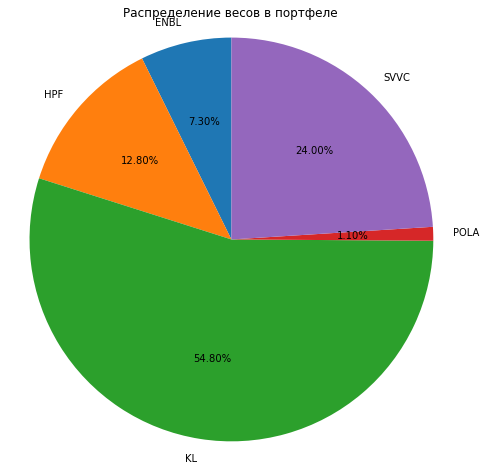

In [137]:
b = 3
x_opt, utility_function_opt = find_optimal_portfolio(calc_utility_function, 
                                                     (means, cov_mat, b), 
                                                     n_stocks=means.shape[0], 
                                                     decimals=3, 
                                                     short_sales=False)

print(f"Оптимальный портфель с отношением к риску, равным {b}: \n {x_opt}")
print(f"Значение целевой функции (-E(x)+ bσ(x)): {utility_function_opt}")

# pie plot
fig1, ax1 = plt.subplots(figsize=(8, 8))
ax1.pie(x_opt[np.where(x_opt != 0)],
        labels=tickers20[np.where(x_opt != 0)],
        autopct='%.2f%%',
        #shadow=True,
        startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Распределение весов в портфеле")
plt.show()

## 2. Оценка неопределенности оптимального портфеля в модели Марковица с заданным отношением к риску.


### 2.1
Задайте число наблюдений $T=30$. С помощью генератора многомерного нормального распределения создайте выборку размера $Т$ из нормального распределения с вектором математических ожиданий $E=(E_1, E_2, …, E_N)$ и матрицей ковариаций $(\sigma_i, \sigma_j)$.

In [76]:
T = 30

np.random.seed(69)
r_sample30 = np.random.multivariate_normal(means.to_numpy(dtype=float).T[0], cov_mat.to_numpy(dtype=float), size=T)
r_sample30 = pd.DataFrame(data = random_sample30, columns=tickers20)
# r_sample30 is a random sample of 30 items

In [77]:
r_sample30

,ALLY,ATRO,BCC,BWFG,CTLT,ENBL,FRBA,HPF,JPS,KL,MHK,MOSY,MUFG,NMRK,OVV,POLA,RARE,RCMT,SNA,SVVC
0,0.012498,0.007385,0.006565,0.021485,-0.012820,0.015263,0.012921,-0.009476,-0.015869,0.015703,0.001321,-0.100428,0.020006,0.013773,0.009415,0.050355,-0.027182,-0.012288,0.002141,-0.023369
1,0.002564,0.020628,-0.011150,0.020845,0.008662,0.000224,0.021649,0.009755,0.010029,-0.015334,-0.002337,-0.110231,-0.001498,0.018173,0.037704,0.042015,-0.019948,-0.014477,-0.005463,0.062083
2,0.020664,-0.014192,0.047335,0.004392,-0.008287,0.020057,-0.006378,0.007738,0.020761,0.034256,0.019367,-0.006046,-0.006997,-0.008532,0.028347,-0.007422,0.043515,0.001750,-0.015206,0.041068
3,-0.012204,-0.009271,-0.011696,-0.005504,-0.000128,0.026613,-0.022321,-0.004594,-0.000435,-0.044962,-0.006786,0.050452,0.000960,-0.018119,0.052211,-0.004621,0.015094,-0.044927,-0.008546,-0.008294
4,-0.025194,-0.027717,-0.035414,-0.028079,-0.017099,-0.028363,-0.022072,-0.016593,-0.014565,0.012776,-0.022305,-0.131324,-0.029223,-0.012354,-0.100466,-0.027101,-0.017333,-0.037561,0.002664,-0.033494
5,0.014330,0.018736,0.004359,-0.002839,-0.033064,0.013605,-0.007546,-0.006065,-0.010935,0.002909,0.009941,0.028698,0.000319,-0.035007,-0.005522,0.003118,-0.035913,-0.002628,0.030498,-0.004569
6,0.014239,0.000784,0.007441,0.014767,0.031796,0.051126,-0.012155,-0.000544,0.004890,-0.000241,0.054474,0.165911,0.017540,0.007255,0.052492,-0.030124,0.066436,-0.005779,0.009814,-0.006746
7,-0.006587,-0.006339,-0.024295,0.002528,-0.001340,-0.008877,-0.014826,-0.001577,0.009219,0.038235,-0.029395,-0.065394,0.009433,-0.017032,-0.003823,-0.046535,-0.015354,0.007591,-0.000077,0.010806
8,-0.014254,-0.028729,-0.045632,-0.012466,-0.051201,-0.002243,-0.010400,-0.009029,-0.017519,-0.010574,-0.028713,-0.282077,-0.027646,-0.012532,-0.035392,0.016675,-0.063259,-0.029846,-0.039123,-0.020248
9,0.010389,-0.003137,0.000973,0.010815,-0.013184,0.007722,-0.001036,0.014415,0.001652,-0.011374,0.027627,0.196058,0.014934,-0.048036,0.004460,0.054082,-0.005792,0.036893,-0.001639,0.047293


### 2.2. 
По построенной выборке сделайте оценку $E_{est}$ вектора математических ожиданий и оценку $(\sigma_{esti}, \sigma_j)$ матрицы ковариаций. 

In [78]:
r_sample30_means = calc_sample_means(r_sample30)
r_sample30_cov_mat = calc_sample_cov(r_sample30, r_sample30_means, verbose=True)

20/20


## 2.3 
Используя эти оценки решите задачу оптимизации

$\begin{cases}  
    -E_{est}(x) + b\sigma_{est}(x) \rightarrow  min \\
    \sum x_i = 1 \\ 
    x_i \ge 0 \quad \forall i
\end{cases}$

Здесь 

$E_{est}(x)= E_{est1}x_1+ E_{est2}x_2+…+ E_{estN}x_N ,$ 

$\sigma_{est}^2(x) =\sum\sum \sigma_{est (i, j)} x_ix_j$

(т.е. найдите выборочный оптимальный портфель с отношением к риску, равным b). Найдите и зафиксируйте веса портфеля и значение целевой функции.


Оптимальный портфель с отношением к риску, равным 3: 
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.278 0.    0.    0.    0.036 0.686]
Значение целевой функции (-E(x)+ bσ(x)): -0.0027620879477074337


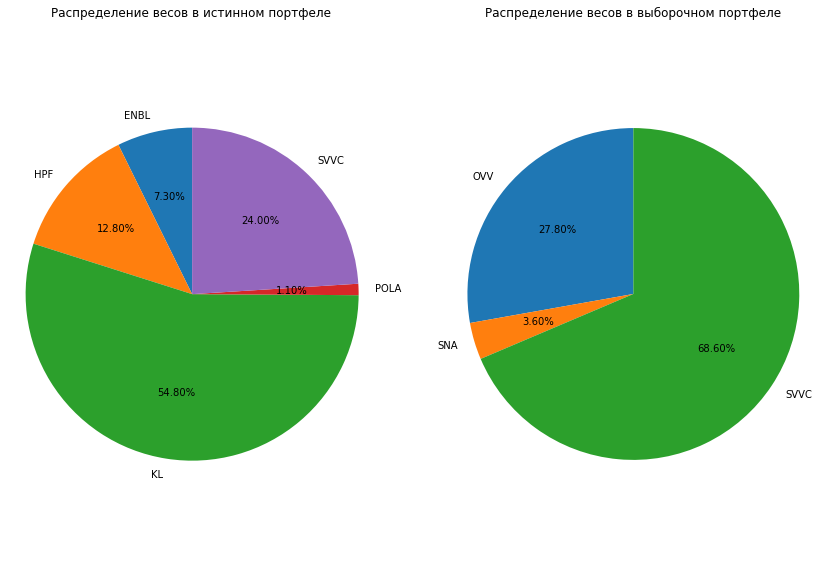

In [135]:
b = 3
x_opt_r_sample30, utility_function_opt_r_sample30 = find_optimal_portfolio(calc_utility_function, 
                                                     (r_sample30_means, r_sample30_cov_mat, b), 
                                                     n_stocks=r_sample30_means.shape[0], 
                                                     decimals=3, 
                                                     short_sales=False)

print(f"Оптимальный портфель с отношением к риску, равным {b}: \n {x_opt_r_sample30}")
print(f"Значение целевой функции (-E(x)+ bσ(x)): {utility_function_opt_r_sample30}")

# pie plot
fig, axs = plt.subplots(1, 2, figsize=(10, 10))

axs[0].pie(x_opt[np.where(x_opt != 0)],
        labels=tickers20[np.where(x_opt != 0)],
        autopct='%.2f%%',
        #shadow=True,
        startangle=90)
axs[0].axis('equal')
axs[0].set_title("Распределение весов в истинном портфеле")

axs[1].pie(x_opt_r_sample30[np.where(x_opt_r_sample30 != 0)],
        labels=tickers20[np.where(x_opt_r_sample30 != 0)],
        autopct='%.2f%%',
        #shadow=True,
        startangle=90)
axs[1].axis('equal') 
axs[1].set_title("Распределение весов в выборочном портфеле")


plt.subplots_adjust(right=1.25)
#plt.title("Сравнение истинного и выборочного портфелей")
plt.show()

### 2.4 
Сравните два портфеля: истинный (п.1) и выборочный (п.2.3). Оцените относительную ошибку в определении весов портфеля в норме Manhattan (L1 норма Минковского). Сделайте выводы. Сделайте сравнение в системе координат $(\sigma, E)$. 

### 2.5. 
Повторите эксперимент $S=40$ раз и оцените среднюю относительную ошибку по $S$ повторениям эксперимента. Сделайте выводы.  Сделайте сравнение в системе координат $(\sigma, E)$. 

### 2.6  
Предположите, что нам известны точные значения математических ожиданий $E=(E_1, E_2, …, E_N)$. Повторите пп. 2.2-2.5. используя оценку только матрицы ковариаций (т.е. решайте задачу оптимизации 

$\begin{cases}  
    -E(x) + b\sigma_{est}(x) \rightarrow  min \\
    \sum x_i = 1 \\ 
    x_i \ge 0 \quad \forall i
\end{cases}$

Здесь 

$E(x)= E_1x_1+E_2x_2+…+E_Nx_N, $

$\sigma_{est}^2(x) =\sum\sum \sigma_{est (i, j)} x_ix_j$ )

Сравните точность этих портфелей и портфелей п.2.3


## 3. Оценка неопределенности оптимального CVaR портфеля 

### 3.1 
Уровень значимости $β$ выбран $0,95$. Число наблюдений $T$. Используя сгенерированные наблюдения из п.2.1 решите задачу ЛП для определения оптимального $CVaRβ$ портфеля.  Найдите и зафиксируйте веса портфеля и значение целевой функции $CVaR$.  

### 3.2 
Сравните два портфеля: истинный (п.1) и найденный в п.3.1.  Оцените относительную ошибку в определении весов портфеля в норме Manhattan (L1 норма Минковского). Сравните с ошибкой портфеля из п. 2.3

### 3.3. 
Повторите эксперимент $S$ раз и оцените среднюю относительную ошибку по S повторениям эксперимента. Сделайте выводы.  Сравните с ошибкой из п. 2.5 